In [7]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout
from keras import backend as K

import math
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)

### Understanding so far:
- Trying to find f such that f(c1, c2, time) = c3
- Because of time we need lstms.
- Final output is linear regression (continuous output)


### TODO:
- Understand how do I input time series data?? all data concatenated together and given together? what about 
  time then? 
- Combine all the data Nikki has shared.

## Reading all data

In [59]:
# Collecting all file names

c1_files = [file for file in glob.glob('Experimental Results' + '/**/C1.txt', recursive=True)]
c2_files = [file for file in glob.glob('Experimental Results' + '/**/C2.txt', recursive=True)]
c3_files = [file for file in glob.glob('Experimental Results' + '/**/C3.txt', recursive=True)]
print('Total c1, c2, c3 files:', len(c1_files), len(c2_files), len(c3_files))

Total c1, c2, c3 files: 44 44 44


In [67]:
# Reading data in all files
def read_files(files):
    x_all, y_all = [], []
    for file in files:
        x,y = [],[]
        for line in open(file, 'r'):
            words = [float(a) for a in line.strip().split(',')]
            x.append(words[0])
            y.append(words[1])
        x_all.append(x)
        y_all.append(y)
    return x_all, y_all

time_c1, c1 = read_files(c1_files)
time_c2, c2 = read_files(c2_files)
time_c3, c3 = read_files(c3_files)

## Check if all data is consistent

### Why are times different?

In [68]:
time_c1[0] == time_c2[0]

False

### Some files of different lengths

In [69]:
len_c1 = np.array([len(a) for a in c1])
len_c2 = np.array([len(a) for a in c2])
len_c3 = np.array([len(a) for a in c3])

def check_inconsistent_data(data1, data2):
    print('File index where data is of different lengths:', np.where(data1 != data2)[0])
    print('Different lengths are:', data1[data1 != data2], data2[data1 != data2])

check_inconsistent_data(len_c1, len_c2)
check_inconsistent_data(len_c1, len_c3)
check_inconsistent_data(len_c2, len_c3)

File index where data is of different lengths: [33]
Different lengths are: [252] [502]
File index where data is of different lengths: [32 33]
Different lengths are: [1002  252] [502 502]
File index where data is of different lengths: [32]
Different lengths are: [1002] [502]


## Lets plot a few files to understand them!

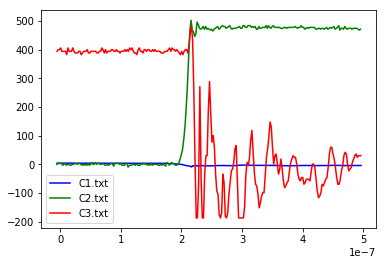

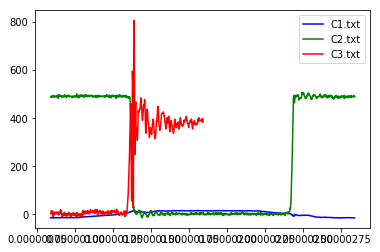

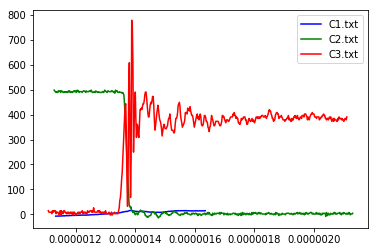

In [70]:
# Change file_indices to see different plots
file_indices = [0, 32, 33]

for file_index in file_indices:
    plt.figure()
    plt.plot(time_c1[file_index], c1[file_index], c = 'b', label='C1.txt')
    plt.plot(time_c2[file_index], c2[file_index], c = 'g', label='C2.txt')
    plt.plot(time_c3[file_index], c3[file_index], c = 'r', label='C3.txt')
    plt.legend()

102 102
102 102
102 102


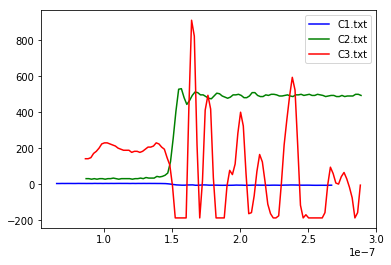

In [117]:
# Change file_indices to see different plots
file_index = 18
print(len(time_c1[file_index]), len(c1[file_index]))
print(len(time_c2[file_index]), len(c2[file_index]))
print(len(time_c3[file_index]), len(c3[file_index]))
file_indices = [18]
for file_index in file_indices:
    plt.figure()
    plt.plot(time_c1[file_index], c1[file_index], c = 'b', label='C1.txt')
    plt.plot(time_c2[file_index], c2[file_index], c = 'g', label='C2.txt')
    plt.plot(time_c3[file_index], c3[file_index], c = 'r', label='C3.txt')
    plt.legend()

### Remove inconsistent data - file indices 32 and 33
- Note that index 33 becomes 32 once index 32 is removed!

In [71]:
del c1[32]
del c1[32]
del c2[32]
del c2[32]
del c3[32]
del c3[32]

In [73]:
# Confirm again if inconsistent data has been removed
len_c1 = np.array([len(a) for a in c1])
len_c2 = np.array([len(a) for a in c2])
len_c3 = np.array([len(a) for a in c3])

check_inconsistent_data(len_c1, len_c2)
check_inconsistent_data(len_c1, len_c3)
check_inconsistent_data(len_c2, len_c3)

File index where data is of different lengths: []
Different lengths are: [] []
File index where data is of different lengths: []
Different lengths are: [] []
File index where data is of different lengths: []
Different lengths are: [] []


## Split into training and testign data - not using validation data as of now!
#### Using approx 80% of files of training and remaining for testing

In [114]:
total_files = len(c1)
print('Total files: ', total_files)

c1_train = c1[0:int(0.8*total_files)]
c2_train = c2[0:int(0.8*total_files)]
c3_train = c3[0:int(0.8*total_files)]
c1_test = c1[int(0.8*total_files):]
c2_test = c2[int(0.8*total_files):]
c3_test = c3[int(0.8*total_files):]

print('Train files: ', len(c1_train))
print('Test files: ', len(c1_test))

Total files:  42
Train files:  33
Test files:  9


## Generate input and output time series data for the NN model

In [131]:
# Create a time unrolled dataset for each set of c1, c2, c3 files
def create_data_per_file(c1_file, c2_file, c3_file, look_back=10):
    x_all, y_all = [], []
    for i in range(len(c1_file) - look_back + 1):
        a = np.concatenate((np.array(c1_file[i:(i + look_back)]).reshape(-1, 1), 
                            np.array(c2_file[i:(i + look_back)]).reshape(-1, 1)), axis = 1)
        x_all.append(a)
        y_all.append(c3_file[i + look_back - 1])
    return np.array(x_all), np.array(y_all)


def create_data_for_all_files(c1_allfiles, c2_allfiles, c3_allfiles, batch_size = 243, batch_overlap = 10, look_back=10):
    x_all, y_all = [], []

    for c1_file, c2_file, c3_file in zip(c1_allfiles, c2_allfiles, c3_allfiles):
        x, y = create_data_per_file(c1_file, c2_file, c3_file, look_back)

        # Don't consider such data
        if x.shape[0] < batch_size:
            continue

        # Need to split the data further into arrays of size batch_size
        elif x.shape[0] > batch_size:
            x_list, y_list = [], []
            for i in range(int((x.shape[0] - batch_size) / batch_overlap) + 1):
                x_list.append(x[i * batch_overlap:(i * batch_overlap + batch_size)])
                y_list.append(y[i * batch_overlap:(i * batch_overlap + batch_size)])
            x_all.extend(x_list)
            y_all.extend(y_list)

        else:
            x_all.append(x)
            y_all.append(y)
    return np.array(x_all).reshape(-1, batch_size, batch_overlap, 2), np.array(y_all).reshape(-1, batch_size, 1)

In [154]:
# loop_back is the time series information. If loop_back is 10, it means we are considering the past 10 (c1, c2) 
# data points to predict the current c3.
# Batch_size = 243 was choosen because the minimum length of most graphs were 252. 
# So batch_size becomes 252 - loop_back +1
# We need batch_overlap because some graphs are of size > 252. Then we need to split them further. So to split
# and to maintain some time series information, we move ahead by only batch_overlap to choose the next batch_size 
# points.
look_back = 10
batch_size = 252 - look_back + 1
batch_overlap = 10

X_train, y_train = create_data_for_all_files(c1_train, c2_train, c3_train, 
                                             batch_size=batch_size, batch_overlap=batch_overlap, look_back=look_back)
X_test, y_test = create_data_for_all_files(c1_test, c2_test, c3_test, 
                                           batch_size=batch_size, batch_overlap=batch_overlap, look_back=look_back)

# The shape should be num_batches x batch_size x loop_back x num_features
# num_features for X is 2 and for y is 1
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1157, 243, 10, 2) (1157, 243, 1)
(234, 243, 10, 2) (234, 243, 1)


In [155]:
# We need to concatenate all of the data points
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(281151, 10, 2) (281151, 1)
(56862, 10, 2) (56862, 1)


## z-score data for the NN model

In [156]:
x_mean = np.mean(np.concatenate(X_train, axis=0), axis=0)
x_std = np.std(np.concatenate(X_train, axis=0), axis=0)
print(x_mean, x_std)

y_mean = np.mean(y_train, axis=0)
y_std = np.std(y_train, axis=0)
print(y_mean, y_std)

[   0.16566758  332.53040042] [   8.63558794  207.98277542]
[ 78.11985988] [ 150.74273376]


In [157]:
X_train = (X_train - x_mean) / x_std
X_test = (X_test - x_mean) / x_std

y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

## Stateful Model

In [160]:
# batch_size = defined above for data generation
# look_back = defined above for data generation
features = 2  # c1, c2

model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, look_back, features), stateful=True, return_sequences=True))
model.add(LSTM(10, stateful=True))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=100, verbose=1, shuffle=False)

Epoch 1/100
281151/281151 [==============================] - 18s - loss: 0.3370    
Epoch 2/100
281151/281151 [==============================] - 18s - loss: 0.2896    
Epoch 3/100
281151/281151 [==============================] - 18s - loss: 0.2838    
Epoch 4/100
281151/281151 [==============================] - 18s - loss: 0.2782    
Epoch 5/100
281151/281151 [==============================] - 19s - loss: 0.2693    
Epoch 6/100
281151/281151 [==============================] - 18s - loss: 0.2577    
Epoch 7/100
281151/281151 [==============================] - 17s - loss: 0.2635    
Epoch 8/100
281151/281151 [==============================] - 18s - loss: 0.2383    
Epoch 9/100
281151/281151 [==============================] - 18s - loss: 0.2294    
Epoch 10/100
281151/281151 [==============================] - 18s - loss: 0.2003    
Epoch 11/100
281151/281151 [==============================] - 17s - loss: 0.1896    
Epoch 12/100
281151/281151 [==============================] - 18s - loss: 

281151/281151 [==============================] - 18s - loss: 0.0790    
Epoch 98/100
281151/281151 [==============================] - 19s - loss: 0.0823    
Epoch 99/100
281151/281151 [==============================] - 19s - loss: 0.0818    
Epoch 100/100
281151/281151 [==============================] - 19s - loss: 0.0846    


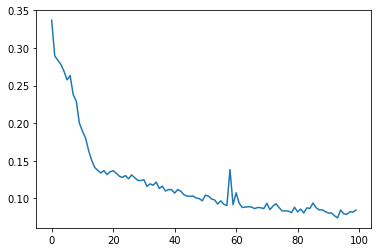

In [166]:
plt.plot(history.epoch, history.history['loss'])

## Plotting for one specific test file

In [182]:
file_index = 1
len(c1_test[1])
X_test_new, y_test_new = create_data_for_all_files([c1_test[file_index]], [c2_test[file_index]], [c3_test[file_index]], 
                                           batch_size=batch_size, batch_overlap=batch_overlap, look_back=look_back)
print(X_test_new.shape, y_test_new.shape)

X_test_new_1 = (X_test_new[0] - x_mean) / x_std
y_test_new_1 = (y_test_new[0] - y_mean) / y_std
print(X_test_new_1.shape, y_test_new_1.shape)

(1, 243, 10, 2) (1, 243, 1)
(243, 10, 2) (243, 1)


In [183]:
y_pred_new = model.predict(X_test_new_1, batch_size=batch_size)
print(X_test_new_1.shape, y_pred_new.shape)

(243, 10, 2) (243, 1)


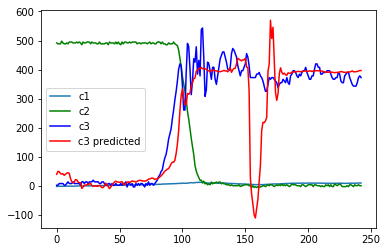

In [184]:
plot_length = 243
plt.plot(range(plot_length), X_test_new[0, :, -1, 0], label='c1')
plt.plot(range(plot_length), X_test_new[0, :, -1, 1], c='g', label='c2')
plt.plot(range(plot_length), y_test_new[0], c='b', label='c3')
plt.plot(range(plot_length), (y_pred_new * y_std) + y_mean, c='r', label='c3 predicted')
plt.legend()

## Predicting for all test data and plotting for random subset of it

In [171]:
y_pred = model.predict(X_test, batch_size=batch_size)
print(X_test.shape, y_pred.shape)

(56862, 10, 2) (56862, 1)


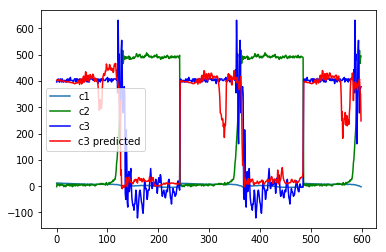

In [186]:
plot_length = 600
plt.plot(range(plot_length), X_test[:plot_length, -1, 0]*x_std[0] + x_mean[0], label='c1')
plt.plot(range(plot_length), X_test[:plot_length, -1, 1]*x_std[1] + x_mean[1], c='g', label='c2')
plt.plot(range(plot_length), y_test[:plot_length]*y_std + y_mean, c='b', label='c3')
plt.plot(range(plot_length), y_pred[:plot_length]*y_std + y_mean, c='r', label='c3 predicted')
plt.legend()

In [152]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_test[:243], y_pred))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 290.85 RMSE
